In [23]:
import segmentation_models_pytorch as smp
import openslide
import torch
from torch.utils.data import DataLoader,Dataset
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import pytorch_model_summary
import pyvips
import matplotlib.pyplot as plt
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
import os
from PIL import Image
device=torch.device("cuda:0") if torch.cuda.is_available() else 'cpu'

In [2]:
class_list = {
    0:['stroma'],
    1:['immune'],
    2:['Normal'], 
    3:['Tumor'],
}
model_path='../../model/NIPA/best_seg_ST_class.pt'
model=smp.Unet(
        encoder_name="efficientnet-b7",
        encoder_weights="imagenet",
        in_channels=3,
        classes=len(class_list),
    ).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()
pytorch_model_summary.summary(model,torch.zeros(1, 3, 1024, 1024).to(device),print_summary=True)

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
            Layer (type)                                                                                                        Output Shape         Param #     Tr. Param #
   EfficientNetEncoder-1     [1, 3, 1024, 1024], [1, 64, 512, 512], [1, 48, 256, 256], [1, 80, 128, 128], [1, 224, 64, 64], [1, 640, 32, 32]      63,786,960      63,786,960
           UnetDecoder-2                                                                                                 [1, 16, 1024, 1024]       3,308,224       3,308,224
                Conv2d-3                                                                                                  [1, 4, 1024, 1024]             580             580
              Identity-4                                                                                                  [1, 4, 1024,

'-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------\n            Layer (type)                                                                                                        Output Shape         Param #     Tr. Param #\n=============================================================================================================================================================================\n   EfficientNetEncoder-1     [1, 3, 1024, 1024], [1, 64, 512, 512], [1, 48, 256, 256], [1, 80, 128, 128], [1, 224, 64, 64], [1, 640, 32, 32]      63,786,960      63,786,960\n           UnetDecoder-2                                                                                                 [1, 16, 1024, 1024]       3,308,224       3,308,224\n                Conv2d-3                                                                                                  [1, 4

In [37]:

color_map = {
    0: [255, 255, 255],      # stroma - red
    1: [0, 255, 0],      # immune - green
    2: [0, 0, 255],      # Normal - blue
    3: [255, 255, 0],    # Tumor - yellow
    
}
slide_path=glob('../../data/BR_HnE/*.ndpi')
for i in range(len(slide_path)):
    slide_image=openslide.OpenSlide(slide_path[i])
    image_size=2024
    thumbnail=slide_image.get_thumbnail((slide_image.dimensions[0]//128, slide_image.dimensions[1]//128))
    slide = pyvips.Image.new_from_file(slide_path[i])

    thumb_mask=cv2.threshold(255-np.array(thumbnail)[:,:,1],30,255,cv2.THRESH_OTSU)[1]
    thumb_mask=cv2.morphologyEx(thumb_mask,cv2.MORPH_CLOSE,np.ones((15,15),np.uint8))
    thumb_mask=cv2.morphologyEx(thumb_mask,cv2.MORPH_OPEN,np.ones((5,5),np.uint8))
    total_patches = (slide.width//image_size-1) * (slide.height//image_size-1)
    predict_mask = np.ones((1024*(slide.height//image_size), 1024*(slide.width//image_size),3), dtype=np.uint8)*255
    for row in tqdm(range(0,slide.height//image_size-1)):
        for col in range(0,slide.width//image_size-1):
            if thumb_mask[row*image_size//128:(row+1)*image_size//128,col*image_size//128:(col+1)*image_size//128].sum()==0:
                predict_mask[row*1024:(row+1)*1024,col*1024:(col+1)*1024]=[255,255,255]
                continue
            patch = slide.crop(col*image_size, row*image_size, image_size, image_size)
            patch = np.ndarray(buffer=patch.write_to_memory(),
                                dtype=np.uint8,
                                shape=[patch.height, patch.width, patch.bands])
            patch=cv2.resize(patch[:,:,:3],(1024,1024),interpolation=cv2.INTER_NEAREST)
            torch_patch=ToTensor()(patch).unsqueeze(0).to(device)
            with torch.no_grad():
                output=model(torch_patch)
                pr_mask=F.softmax(output,dim=1)
                pr_mask = torch.where(pr_mask>0.5,1,0).cpu().numpy()
            pr_mask=np.argmax(pr_mask,axis=1)
            pr_mask_rgb=np.zeros((1024,1024,3),dtype=np.uint8)
            for k,v in color_map.items():
                pr_mask_rgb[pr_mask[0]==k]=v
            predict_mask[row*1024:(row+1)*1024,col*1024:(col+1)*1024]=pr_mask_rgb

    predict_mask=cv2.resize(predict_mask,(slide.width//128,slide.height//128),interpolation=cv2.INTER_NEAREST)
    Image.fromarray(predict_mask).save(f'../../results/{os.path.basename(slide_path[i])[:-5]}.png')

100%|██████████| 41/41 [05:49<00:00,  8.52s/it]


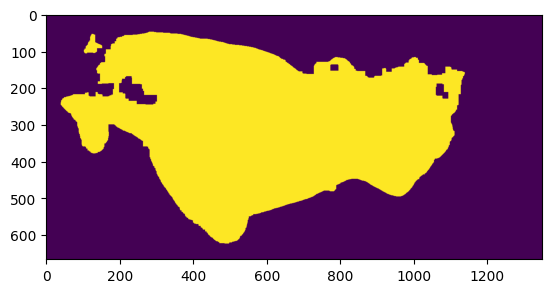

In [36]:
thumb_mask=cv2.threshold(255-np.array(thumbnail)[:,:,1],30,255,cv2.THRESH_OTSU)[1]
thumb_mask=cv2.morphologyEx(thumb_mask,cv2.MORPH_CLOSE,np.ones((15,15),np.uint8))
thumb_mask=cv2.morphologyEx(thumb_mask,cv2.MORPH_OPEN,np.ones((5,5),np.uint8))
plt.imshow(thumb_mask)